Trying to combine the watershed appraoch with the hessian thresholding to find starting points (to keep lack of size bias)

In [12]:
# fmt: off
import numpy as np
import skimage as sk
import scipy as sp
import h5py
import os
import copy
import pickle
import shutil
import pandas as pd
import paulssonlab.deaton.trenchripper.trenchripper as trenchripper

from skimage import measure,feature,segmentation,future,util,morphology,filters,exposure,transform
from paulssonlab.deaton.trenchripper.trenchripper import kymo_handle,pandas_hdf5_handler,writedir
from paulssonlab.deaton.trenchripper.trenchripper import hdf5lock
from time import sleep
import scipy.ndimage.morphology as morph
# import mahotas as mh
from dask.distributed import worker_client
from pandas import HDFStore
import matplotlib

from matplotlib import pyplot as plt

In [13]:
matplotlib.rcParams["figure.figsize"] = [20, 10]

In [14]:
class fluo_segmentation:
    def __init__(self,scale_timepoints=False,scaling_percentage=0.9,smooth_sigma=0.75,bit_max=0,wrap_pad=3,hess_pad=6,min_obj_size=30,cell_mask_method='global',global_threshold=1000,\
                 cell_otsu_scaling=1.,local_otsu_r=15,edge_threshold_scaling=1.):

        self.scale_timepoints=scale_timepoints
        self.scaling_percentage=scaling_percentage
        self.smooth_sigma = smooth_sigma
        self.bit_max = bit_max
        self.wrap_pad = wrap_pad
        self.hess_pad = hess_pad
        self.min_obj_size = min_obj_size
        self.global_threshold = global_threshold
        self.cell_mask_method = cell_mask_method
        self.cell_otsu_scaling = cell_otsu_scaling
        self.local_otsu_r = local_otsu_r
        self.edge_threshold_scaling = edge_threshold_scaling

    def scale_kymo(self,wrap_arr,percentile):
        perc_t = np.percentile(wrap_arr[:].reshape(wrap_arr.shape[0],-1),percentile,axis=1)
        norm_perc_t = perc_t/np.max(perc_t)
        scaled_arr = wrap_arr.astype(float)/norm_perc_t[:,np.newaxis,np.newaxis]
        scaled_arr[scaled_arr>255.] = 255.
        scaled_arr = scaled_arr.astype("uint8")
        return scaled_arr

    def to_8bit(self,img_arr,bit_max=None):
        img_max = np.max(img_arr)+0.0001
        if bit_max is None:
            max_val = img_max
        else:
            max_val = max(img_max,bit_max)
        min_val = np.min(img_arr)
#         min_val = np.min(img_arr)
        norm_array = (img_arr-min_val)/(max_val-min_val)
        norm_byte_array = sk.img_as_ubyte(norm_array)
        return norm_byte_array

    def preprocess_img(self,img_arr,sigma=1.,bit_max=0,scale_timepoints=False,scaling_percentage=None):
        img_smooth = copy.copy(img_arr)
        for t in range(img_arr.shape[0]):
            img_smooth[t] = self.to_8bit(sk.filters.gaussian(img_arr[t],sigma=sigma,preserve_range=True,mode='reflect'),bit_max=bit_max)
        if scale_timepoints:
            img_smooth = self.scale_kymo(img_smooth,scaling_percentage)

        return img_smooth

    def cell_region_mask(self,img_arr,method='global',global_threshold=1000,cell_otsu_scaling=1.,local_otsu_r=15):
        global_mask_kymo = []
        for t in range(img_arr.shape[0]):
            cell_mask = img_arr[t,:,:]>global_threshold
            global_mask_kymo.append(cell_mask)
        global_mask_kymo = np.array(global_mask_kymo)

        if method == 'global':
            return global_mask_kymo

        elif method == 'local':
            otsu_selem = sk.morphology.disk(local_otsu_r)
            local_mask_kymo = []
            for t in range(img_arr.shape[0]):
                above_threshold = np.any(global_mask_kymo[t,:,:]) # time saving
                if above_threshold:
                    local_thr_arr = sk.filters.rank.otsu(img_arr[t,:,:], otsu_selem)
                    local_mask = img_arr[t,:,:]>local_thr_arr
                else:
                    local_mask = np.zeros(img_arr[t,:,:].shape,dtype=bool)
                local_mask_kymo.append(local_mask)
            local_mask_kymo = np.array(local_mask_kymo)

            final_cell_mask = global_mask_kymo*local_mask_kymo
            del global_mask_kymo
            del local_mask_kymo
            return final_cell_mask

        else:
            print("no valid cell threshold method chosen!!!")

    def hessian_contrast_enc(self,img_arr,edge_padding=0):
        img_arr = np.pad(img_arr, edge_padding, 'reflect')
        hessian = sk.feature.hessian_matrix(img_arr,order="rc")
        eigvals = sk.feature.hessian_matrix_eigvals(hessian)
        min_eigvals = np.min(eigvals,axis=0)
        if edge_padding>0:
            min_eigvals = min_eigvals[edge_padding:-edge_padding,edge_padding:-edge_padding]
        return min_eigvals

    def find_mask(self,cell_local_mask,min_eigvals,edge_threshold,min_obj_size=30):
        edge_mask = min_eigvals>edge_threshold
        composite_mask = cell_local_mask*edge_mask
        composite_mask = sk.morphology.remove_small_objects(composite_mask,min_size=min_obj_size)
        composite_mask = sk.morphology.remove_small_holes(composite_mask)
        return composite_mask

    def get_mid_threshold_arr(self,wrap_eig,edge_threshold_scaling=1.,padding=3): ##???BAD
        edge_threshold_kymo = []
        for t in range(wrap_eig.shape[0]):
            edge_threshold = sk.filters.threshold_otsu(wrap_eig[t])
            edge_thr_arr = edge_threshold*np.ones(wrap_eig.shape[1:],dtype='uint8')
            edge_threshold_kymo.append(edge_thr_arr)
        edge_threshold_kymo = np.array(edge_threshold_kymo)*edge_threshold_scaling
#         edge_threshold_kymo = np.moveaxis(edge_threshold_kymo,(0,1,2),(2,0,1))

        edge_thr_kymo = kymo_handle()
        edge_thr_kymo.import_wrap(edge_threshold_kymo,scale=False)
        mid_threshold_arr = edge_thr_kymo.return_unwrap(padding=padding)
        return mid_threshold_arr
    
    

    def segment(self,img_arr): #img_arr is t,y,x
#         input_kymo = kymo_handle()
#         input_kymo.import_wrap(img_arr,scale=self.scale_timepoints,scale_perc=self.scaling_percentage)
        img_arr_new = []    
        for t in range(img_arr.shape[0]):
            image_rescaled = transform.rescale(img_arr[t], 2., anti_aliasing=False, preserve_range=True)
            img_arr_new.append(image_rescaled)
        img_arr = np.array(img_arr_new,dtype="uint16")
    
        t_tot = img_arr.shape[0]
        working_img = self.preprocess_img(img_arr,sigma=self.smooth_sigma,bit_max=self.bit_max,\
                                         scale_timepoints=self.scale_timepoints,scaling_percentage=self.scaling_percentage) #8_bit

        temp = kymo_handle()
        temp.import_wrap(working_img)
        temp = temp.return_unwrap(padding=self.wrap_pad)

        inverted = np.array([sk.util.invert(working_img[t]) for t in range(working_img.shape[0])])
        min_eigvals = np.array([self.to_8bit(self.hessian_contrast_enc(inverted[t],self.hess_pad)) for t in range(inverted.shape[0])])
        del inverted
        cell_mask = self.cell_region_mask(working_img,method=self.cell_mask_method,global_threshold=self.global_threshold,cell_otsu_scaling=self.cell_otsu_scaling,local_otsu_r=self.local_otsu_r)

        mid_threshold_arr = self.get_mid_threshold_arr(min_eigvals,edge_threshold_scaling=self.edge_threshold_scaling,padding=self.wrap_pad)

        cell_mask_kymo = kymo_handle()
        cell_mask_kymo.import_wrap(cell_mask)
        cell_mask = cell_mask_kymo.return_unwrap(padding=self.wrap_pad)

        min_eigvals_kymo = kymo_handle()
        min_eigvals_kymo.import_wrap(min_eigvals)
        min_eigvals = min_eigvals_kymo.return_unwrap(padding=self.wrap_pad)
        
        hessian_mask = self.find_mask(cell_mask,min_eigvals,mid_threshold_arr,min_obj_size=self.min_obj_size)
#         labeled = sk.measure.label(hessian_mask,neighbors=4,connectivity=2)
#         rps = sk.measure.regionprops(labeled)
#         centroid_list = [rp.centroid for rp in rps]
#         rounded_centoid_arr = np.array([[np.round(centroid[0]),np.round(centroid[1])] for centroid in centroid_list],dtype=int)
#         centers_arr = np.zeros(labeled.shape,dtype=bool)
#         centers_arr[rounded_centoid_arr[:,0],rounded_centoid_arr[:,1]]=True
#         markers = sk.measure.label(centers_arr)
        
#         distance = ndi.distance_transform_edt(cell_mask)
#         labels = watershed(-distance, markers, mask=distance)
#         temp_output = labels>0
#         for label in np.unique(labels):
#             one_obj = (labels==label)
#             eroded = sk.morphology.binary_dilation(one_obj)
#             border = eroded^one_obj
#             temp_output[border] = False    
        del cell_mask
        del min_eigvals
        del mid_threshold_arr

        output_kymo = kymo_handle()
        output_kymo.import_unwrap(hessian_mask,t_tot,padding=self.wrap_pad)
        segmented = output_kymo.return_wrap()
        
        segmented_new = []
        for t in range(segmented.shape[0]):
            image_rescaled = transform.rescale(segmented[t], 1./2., anti_aliasing=False,order=0,preserve_range=True)
            segmented_new.append(image_rescaled)
        segmented = np.array(segmented_new,dtype=bool)
        return segmented

In [15]:
test = fluo_segmentation(smooth_sigma=0.5,bit_max=20000,scale_timepoints=False,scaling_percentage=0.9,min_obj_size=8,cell_mask_method='local',\
                         global_threshold=25,cell_otsu_scaling=1.5,local_otsu_r=7,edge_threshold_scaling=1.2)

In [46]:
with h5py.File("/n/scratch2/de64/2020-03-02_plasmid_loss/kymograph/kymograph_154.hdf5","r") as infile:
    data = infile['mCherry'][:]

In [47]:
data.shape

(50, 275, 215, 9)

In [62]:
output = test.segment(data[10,150:155])
temp = kymo_handle()
temp.import_wrap(output)
outlplot = temp.return_unwrap()
temp.import_wrap(data[10,150:155])
outlplot2 = temp.return_unwrap()

In [63]:
labeled = sk.measure.label(outlplot[:,:200],neighbors=4,connectivity=2)
rps = sk.measure.regionprops(labeled)
centroid_list = [rp.centroid for rp in rps]
rounded_centoid_arr = np.array([[np.round(centroid[0]),np.round(centroid[1])] for centroid in centroid_list],dtype=int)
centers_arr = np.zeros(labeled.shape,dtype=bool)
centers_arr[rounded_centoid_arr[:,0],rounded_centoid_arr[:,1]]=True
markers = sk.measure.label(centers_arr)
distance = ndi.distance_transform_edt(outlplot[:,:200])
labels = watershed(-distance, markers, mask=outlplot[:,:200])

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=4, use connectivity=1
  """Entry point for launching an IPython kernel.


NameError: name 'ndi' is not defined

In [ ]:
plt.imshow(outlplot2)
plt.show()

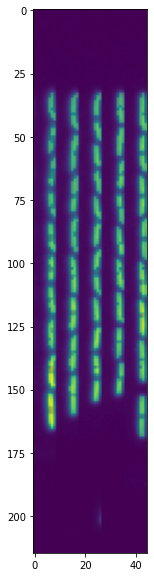

In [64]:
plt.imshow(outlplot2)
plt.imshow(outlplot,alpha=0.2)
plt.show()

In [115]:
rounded_centoid_arr[:,1]

array([  5,  14,  23,  32, 140, 149, 158, 185, 194,  41,  50,  60,  69,
        78,  87,  96, 104, 113, 123, 131, 176, 167,  14,  60,  32, 104,
       140,   5,  23, 149,  41,  69, 113, 122, 176,  50,  77, 158,  14,
        86,  32,  23,  96, 131,  41,  59, 140, 104, 167,   5,  50,  68,
       113, 149,  14,  32, 176, 123,  23,  59,  77,   5,  41, 185, 104,
       158,  50,  68,  86, 131,  95, 113, 140,  77, 176,  32,  59, 194,
        23, 167,  14,  50,  86, 104, 123, 149,   5,  68,  77,  41,  96,
       113, 176,  59,  86, 167, 104, 158,  50,  77, 131,  14,  23,  32,
       185, 122,   5,  96, 149,  68,  41, 113,  86, 140,  60, 131, 176,
       167,  32, 104,  23,  41,  77,   5,  50, 122,  86,  95, 158, 194,
        14, 185,  59,  68, 131, 140, 149,  32,  41, 167, 176,  23,  50,
       113,  14,  86, 122,  32, 104,  95, 140,  41,  59,   5,  77, 131,
        50,  68, 149, 185, 113, 167, 158, 194,  86,  14,  23,  32,  77,
       122,   5,  59,  41,  95,  50, 104, 113, 140,  68, 149,  8

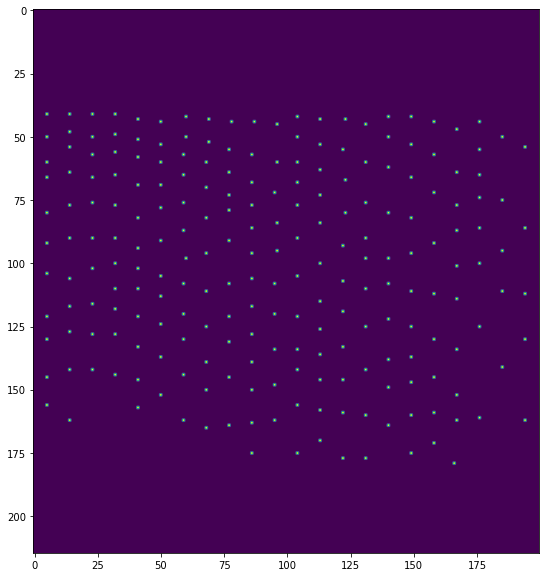

In [117]:
plt.imshow(centers_arr)

In [62]:
centroid_list = [rp.centroid for rp in rps]

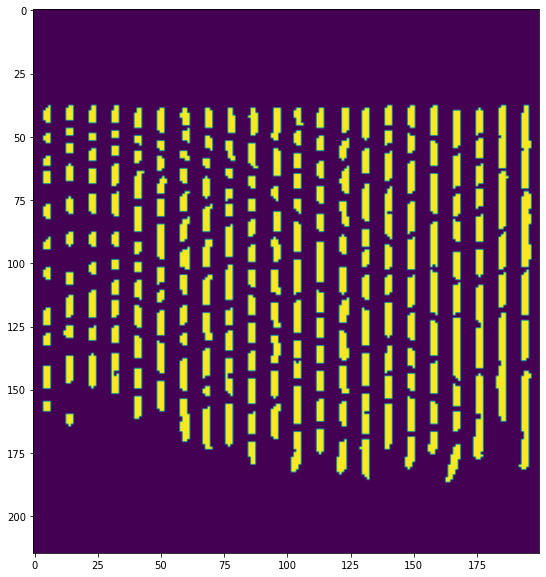

In [52]:
plt.imshow(outlplot[:,:200])

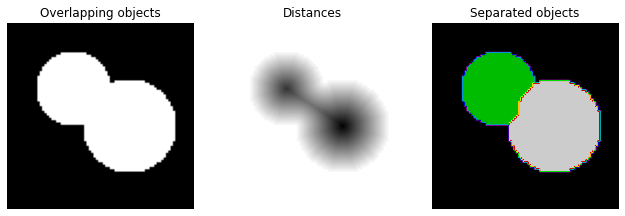

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()